In [1]:
from __future__ import division, unicode_literals, print_function  
import numpy as np
import matplotlib.pyplot as plt
import pims  # image reading routines
import os

import pandas as pd
#from pandas import DataFrame, Series  

import trackpy as tp
from scipy import ndimage  # for shifting images
from pims import pipeline
from pims import Frame
from scipy.interpolate import griddata  # for resampling
import matplotlib.patches as mpatches   # circles
from scipy.signal import savgol_filter
from skimage.transform import rotate
from matplotlib import cm


%load_ext autoreload
%autoreload 2

%matplotlib inline

from track_lib import  *  # some subroutines writting specifically for tracking

#tutorials for trackpy
#http://soft-matter.github.io/trackpy/v0.3.0/tutorial/walkthrough.html

In [2]:
# to do: try smoothing before tracking, no joy
# try cross corr on top view, working on it

In [3]:
# read in frames
framesrgb_s = pims.open('frame_dir/cc02/img_*.png')  # this is side view
framesrgb_a = pims.open('frame_dir/cc02/img_*.png')  # this is above view
# that was processed with
#ffmpeg -i vid02s.mp4    -ss 00:00:9.000 -vframes 1000 s_%04d.png -hide_banner

fps = 4532.87

In [4]:
#ruler above using imagej 447 pixels which is 1 inch giving 447/25.4 = 17.598 mm/pixel
#ruler side 80.0 is 1 cm giving 8.0 mm/pixel 

#pixscale_s=12.9  # measured using imagej  from ruler video frames pixels per mm
pixscale_a=17.7   # pixels per mm 

In [5]:
print(framesrgb_a[0].shape, len(framesrgb_a)) 
nx = framesrgb_a[0].shape[1]

(240, 1280, 3) 1200


185


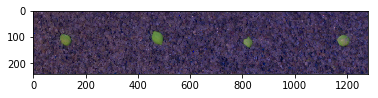

In [6]:
nw = 1280 # width of region we care about 
nh = 240 # height of region we care about
yy0 = 0; yy1=nh+yy0; xx0 = 0; xx1 = xx0+nw  # specify region
plt.imshow(framesrgb_a[0][yy0:yy1,xx0:xx1,:])  # green is best for seeing dots?
#plt.colorbar()
print(np.max( framesrgb_a[0][yy0:yy1,xx0:xx1,1]))

In [7]:
# make a blue version of above view
processed_video_blue_a = color_rgb(framesrgb_a,yy0,yy1,xx0,xx1,0,0,1)

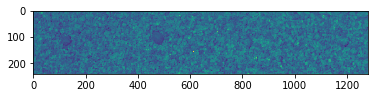

In [8]:
plt.imshow(processed_video_blue_a[0])

In [9]:
#from scipy.signal import correlate # (in1, in2, mode='full', method='auto')
#from scipy.signal import correlation_lags
#from scipy import signal
from scipy.signal import correlate2d
#https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.correlate2d.html


# do a cross correlation, fa is the frame from which we choose template subimages
# fb is the image we find where fa template resides in it
# i0:i1 horizontal index range for template
# j0:j1 vertical index range for both
# frames is pims image sequence
# if showit==1 then show the images
# return a peak position in pixels 
def crosscor_2frames(frames,fa,fb,i0,i1,j0,j1,showit):
    framea = np.array(frames[fa][j0:j1,:])  # this is one frame (a)
    framea -= framea.mean()
    frameb = np.array(frames[fb][j0:j1,:])  # this is another frame (b)
    frameb -= frameb.mean()
    template = framea[:,i0:i1] #take a small box from the a frame
    template -= template.mean()
    # do the cross correlation
    corr = correlate2d(frameb, template, boundary='symm', mode='same')  # boundary could be "fill"
#     print(corr)
#     print(framea.shape,frameb.shape,template.shape,corr.shape)
    yi, xi = np.unravel_index(np.argmax(corr), corr.shape)  # find peak position in pixels
    if (showit==1):
        fig, (ax_orig, ax_template, ax_corr) = plt.subplots(1, 3,figsize=(8,2),dpi=340)
        ax_orig.imshow(frameb, cmap='gray')
        ax_template.imshow(template, cmap='gray')
        ax_corr.imshow(corr, cmap='gray')
        ax_orig.plot(xi, yi, 'ro', ms=1)
    midpt = (i0+i1)/2  # this is the relative shift I think, it is the midpoint position of the template image
    #print(x,y,midpt)
    #return xi,yi,midpt,framea
    return xi,yi,midpt

#tests
#fa=110; fb=110; i0=800; i1=100+i0; j0 = 60; j1=j0+100
#x,y,midpt = crosscor_2frames(processed_video_blue_a,fa,fb,i0,i1,j0,j1)
    
# do a series of cross correlations at a single time 
# here fa is the initial frame from which we choose templates
# fb is the other image in which we find where fa templates reside
# we choose a series of template positions moving across the image 
# di is horizontal width in pixels of template images 
# dishift is how much to shift the template centre for each cross correlation done
# j0:j1 vertical index range used in images
def cross_corr_series(frames,fa,fb,di,dishift,j0,j1):
    ni = find_nt(frames,di,dishift)  # number of cross correlations we are going to do
    # allocate some arrays for storing results of cross correlation!
    xarr = np.zeros(ni)
    yarr = np.zeros(ni)
    midpt_arr = np.zeros(ni)
    for i in range(ni):
        i0 = dishift*i
        i1 = i0+di
        xi,yi,midpt = crosscor_2frames(frames,fa,fb,i0,i1,j0,j1,0)
        xarr[i]= xi
        yarr[i]= yi
        midpt_arr[i] = midpt
    diff_arr = xarr-midpt_arr+1  # should be the shift in pixels 
   # print(diff_arr)
    return diff_arr,midpt_arr  # return the shift in pixels

# figure out how many locations of templates
# returns an integer 
def find_nt(frames,di,dishift):
    ff = frames[0].shape
    nx = ff[1]  #horizontal length of image
    ny = ff[0] # vertical length of image
    imax = nx - di  
    nt = int(imax/dishift)  # number of cross correlatioins we are going to do
    #print(nt)
    return nt
    
# tests
#fa=110; fb=110; di=100; dishift=50; j0 = 60; j1=j0+100
#xarr,yarr,midpt_arr = cross_corr_series(processed_video_blue_a,fa,fb,di,dishift,ni,j0,j1)

In [10]:
## Note that in the script for the cross-correlation of vid02a.mp4 fa was 110. 
## Frames were extracted from the video starting at 9sec (at 60fps playback) or 540frames. 
## A value of fa=110 put the frame of impact to be 650.

## For this video (and others taken on 05/20/2022), take fa to be frame 650;
## This matches the frame/time of impact from vid02s.mp4 as explained above.

## Also 650/4532.87fps ~ 144ms which is just before the pulse arrives at first accelerometer;
## This agreement is across many accelerometer data sets.
## Since the drop height of the projectile and the IR-breakbeam trigger have not moved, taking
## fa=650 for these videos seems reasonable.

In [11]:
## Choose parameters for a cross correlation 
nf = 40  # number of frames to do (giving a time sequence)
df_shift = 5  # shift between frames for time series 
fa=650;  #initial image: templates taken from this
di=64;   # horizontal width of templates
dishift=50; # shift for each template image in pixels 
j0 = 40; j1=j0+di   # vertical range to grab subimages
nt=find_nt(processed_video_blue_a,di,dishift)  # number of templates
diff_all = np.zeros([nf,nt])  # nt is the number of templates for horizontal distances
midpt_all = np.zeros([nf,nt])
dt = 1/fps 

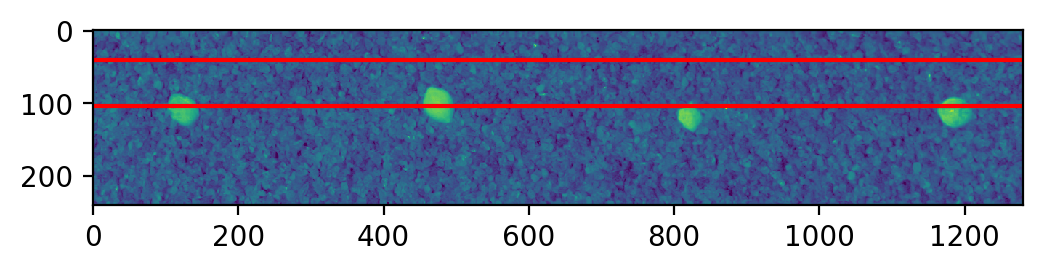

In [12]:
fig,ax = plt.subplots(1,1,dpi=200)
ax.imshow(framesrgb_a[0][yy0:yy1,xx0:xx1,1])  # green is best for seeing dots?
ax.plot([0,1279],[j0,j0],'r')
ax.plot([0,1279],[j1,j1],'r')

In [13]:
## Fill a 2d array with cross corr shifts in one axis
## and in time in the other axis 
for k in range(nf):  # loop over a series of images 
    fb = fa+k*df_shift  # each separated by df_shift frames in time 
    print(fb)
    diff_arr,midpt_arr = cross_corr_series(processed_video_blue_a,fa,fb,di,dishift,j0,j1)
    diff_all[k,:] = diff_arr   
    midpt_all[k,:] = midpt_arr
# this takes a while, like 10 minutes 

650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845


In [14]:
diff_all_mm = -1*np.copy(diff_all)  # flip sign
#iii = (diff_all_mm > 30) # garbage!
#diff_all_mm[iii] = -1  #get rid of garbage,  clean the shift image 

#get rid of garbage,  clean the shift image via masking
diff_all_mm = np.ma.masked_where((diff_all_mm > 30), diff_all_mm ) 

diff_all_mm /= pixscale_a # put shifts in mm

In [15]:
# ## Save cross correlation result
# np.save('cc_cc02_values_high', diff_all_mm.data)
# np.save('cc_cc02_mask_high', diff_all_mm.mask)

# np.save('cc_cc02_midpts_high', midpt_all)

In [16]:
# ## Load cross correlation result
# diff_all_vals = np.load('cc_vid02a_values.npy')
# diff_all_mask = np.load('cc_vid02a_mask.npy')
# midpt_all = np.load('cc_vid02a_midpts.npy')

# # Make masked array with values and mask
# diff_all_mm = np.ma.masked_array(diff_all_vals,diff_all_mask) 

# Plot results

74.63276836158192


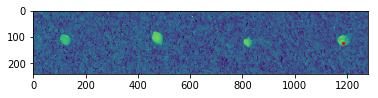

In [17]:
## Find location of millet grain closest to impact
## this is to set correct values of position
px_loc = 1185 # pixels; location of grain closest to impact site
real_loc = 80.0 # mm; measured distance from closest grain to impact site

plt.imshow(framesrgb_a[0][yy0:yy1,xx0:xx1,1])  # green is best for seeing dots?
plt.scatter(px_loc, 120, s=5, c='r') 

coord_shift = real_loc - ( nx - px_loc )/pixscale_a # shift coordinates to measured millet locations
print(coord_shift)

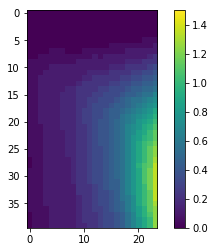

In [18]:
plt.imshow(diff_all_mm,vmin=0,vmax=1.5)
plt.colorbar()
# color bar is shift in mm
# top is no displacement at impact time 
# vertical is time
# horizontal is x position 

In [32]:
## Parameters for meshgrid and color
#dx = np.linspace(sx,nt*dishift/pixscale_a,nt)  # horizontal distance (not center yet) from right side of image
Rc = 50.0 # 50 mm crater radius; for scaling x-axis in cell below
dx = np.linspace(coord_shift/Rc, (nt*dishift/pixscale_a+coord_shift)/Rc, nt)  # horizontal distance from right side of image
dy = np.linspace(0, nf*df_shift*dt*1e3, nf)  # time from time of touch
# time of touch has a hardcoded value of 0; just be aware
x_mesh, y_mesh = np.meshgrid(dx,dy)  # for plotting with pcolormesh
print('max distance {:.1f} mm,  max time {:.1f} ms'.format( dx[-1],dy[-1]) )  # max distance in mm and max time

#extent_diff = np.array([0,nt*dishift/pixscale_a,0,nf*df_shift*dt*1e3],dtype=float)  # for making figures with imshow

max distance 2.8 mm,  max time 44.1 ms


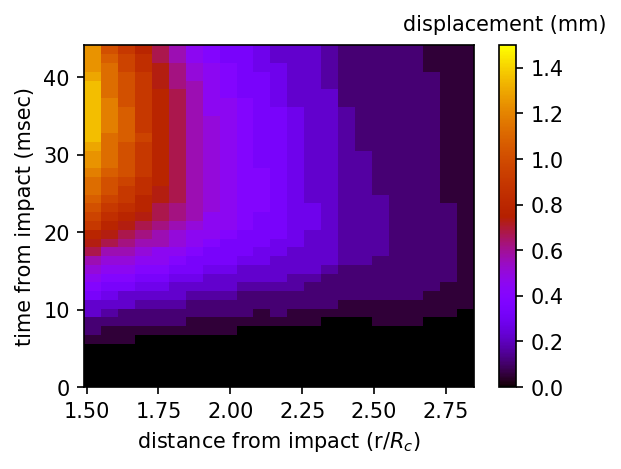

In [61]:
## Plot the displacements as a function of time 
fig,ax = plt.subplots(1,1,figsize=(5,3),dpi=150)
#
plt.subplots_adjust(hspace=0,wspace=0,top=0.92, bottom=0.16, left=0.2,right=0.85)
z1 = np.flip(diff_all_mm,axis=1) # now impact is on the left
#z = np.flip(z1,axis=0) # flip vertical
pcm= ax.pcolormesh(x_mesh,y_mesh,z1,vmin=0,vmax=1.5,cmap='gnuplot') 
plt.colorbar(pcm, ax=ax)
#ax.contour(x_mesh,y_mesh,z1,levels=[0,0.1,0.2,0.3])
ax.set_xlabel('distance from impact (r/$R_c$)')
ax.set_ylabel('time from impact (msec)')
ax.text(2.6,46,'displacement (mm)')
plt.savefig('cross_corr_cc02_Rc.png',dpi=400) 
#ax.xaxis.set_major_locator(plt.MaxNLocator(10)) 

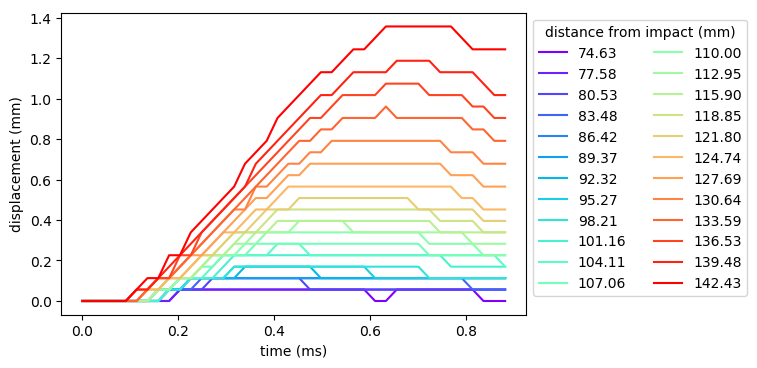

In [21]:
## displacement vs time from cross correlation result
# each curve is a column in the cross correlation
color = iter(cm.rainbow(np.linspace(0, 1, nt)))

fig,ax = plt.subplots(1,1,dpi=100) 
for xx in range(nt):
    current_color=next(color) 
    ax.plot(dy,diff_all_mm[:,xx],c=current_color,label='{:.2f}'.format(dx[xx])) 
    
plt.ylabel('displacement (mm)') 
plt.xlabel('time (ms)') 
plt.legend(ncol=2,bbox_to_anchor=(1.0,1.0),title='distance from impact (mm)') 